# Sentimental analysis of 21 July 2021 tweets to predict the return of Bitcoin

In [ ]:
#Libraries for the 
import os
import tweepy as tw
import pandas as pd
from matplotlib import pyplot as plt #(matplotblib)
import seaborn as sns #(visualsize)

In [11]:
#Twitter Developer Account Access Keys
consumer_key= 'ATqgLB70FlSN0n1jKiLb1Pqe2'
consumer_secret= 'hnR3v9Ha2O85KhfpYnlmHSkNdVzLfSpPHllL9Y0J3c6OKxrXWV'
access_token= '1890225936-FvuNZEzbIit0WGgSJz16dGFRBdAPFWJ4hSYREuk'
access_token_secret= 'EKEMlUajJBxCCe3qBdOZcE6DDQ6vnS3LdCyo2uPY9HeY6'

In [15]:
# Connection with Twiiter Developer Accont to extract the Twitters
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)


In [21]:
# To extract tweets, count 20000 tweets to be extracted with 4 features.

search_words = "#Bitcoin" 
new_search = search_words + " -filter:retweets"
date_since = "2021-07-16"
tweets = tw.Cursor(api.search, 
                   q=new_search,
                           lang="en",
                           since=date_since).items(20000)

users_locs = [[tweet.user.screen_name, tweet.user.location,tweet.text,tweet.created_at.date()] for tweet in tweets]

data = pd.DataFrame(data=users_locs, 
                    columns=['user', "location","text","date"])


len(data)


20000

In [23]:
#Preprocessing of text tweets to remove : Punction, Numbers, stropwords hash tages , links stemming, lematization


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english') and "amp"]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


data['cleanText']=data['text'].map(lambda s:preprocess(s)) 

In [24]:
# textblob library to extract the polarity score to find sentiments

import nltk
from textblob import  TextBlob
data['TextBlob Score']=""
data['TextBlob Sentiment']=""
#df2 = pd.DataFrame(columns=['text', 'sentiment', 'score'])
data['cleanText']=data['cleanText'].astype(str)
for i in range(len(data)):
    sentiment = TextBlob(data['cleanText'][i])
    a=sentiment.sentiment.polarity
    #df2.loc[i] = [data['cleanText'][i]]+[str(0)]+ [a]
    data["TextBlob Score"][i]=a

for i in range(len(data)):
    if(data['TextBlob Score'][i]>0):
        data['TextBlob Sentiment'][i]="Positive"
    elif(data['TextBlob Score'][i]==0):
        data['TextBlob Sentiment'][i]="Neutral"
    else:
        data['TextBlob Sentiment'][i]="Negative"

In [25]:
# import SentimentIntensityAnalyzer class 
# from vaderSentiment.vaderSentiment module.

VADER (Valence Aware Dictionary and sEntiment Reasoner) 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
data["Vader Score"]=0
data["Vader Sentiment"]=0
sid_obj = SentimentIntensityAnalyzer() 
# function to print sentiments 
# of the sentence. 
for i in range(len(data)):

    # Create a SentimentIntensityAnalyzer object. 
    

    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(data["cleanText"][i])  
    # decide sentiment as positive, negative and neutral 
    if sentiment_dict['compound'] >= 0.05 : 
        data["Vader Score"][i]= str(sentiment_dict['compound'])
        data["Vader Sentiment"][i]= "Positive"
        

    elif sentiment_dict['compound'] <= - 0.05 : 
        data["Vader Score"][i]= str(sentiment_dict['compound']) 
        data["Vader Sentiment"][i]= "Negative"

    else : 
        data["Vader Score"][i]= str(sentiment_dict['compound'])
        data["Vader Sentiment"][i]= "Neutral"





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
data[:2]

,user,location,text,date,cleanText,TextBlob Score,TextBlob Sentiment,Vader Score,Vader Sentiment
0,Fisherman_SU,,"If this #Bitcoin has depreciated, it has lost ...",2021-07-21,bitcoin depreciated lost value due unconscious...,-0.0875,Negative,-0.4767,Negative
1,bitcoinermike,Sydney 🇦🇺,If #bitcoin is too much then think satoshis,2021-07-21,bitcoin much think satoshis,0.2,Positive,0.0,Neutral


In [28]:
from collections import Counter
Counter(data["TextBlob Sentiment"])

Counter({'Negative': 2376, 'Positive': 7636, 'Neutral': 9988})

In [29]:
from collections import Counter
Counter(data["Vader Sentiment"])

Counter({'Negative': 2631, 'Neutral': 7889, 'Positive': 9480})

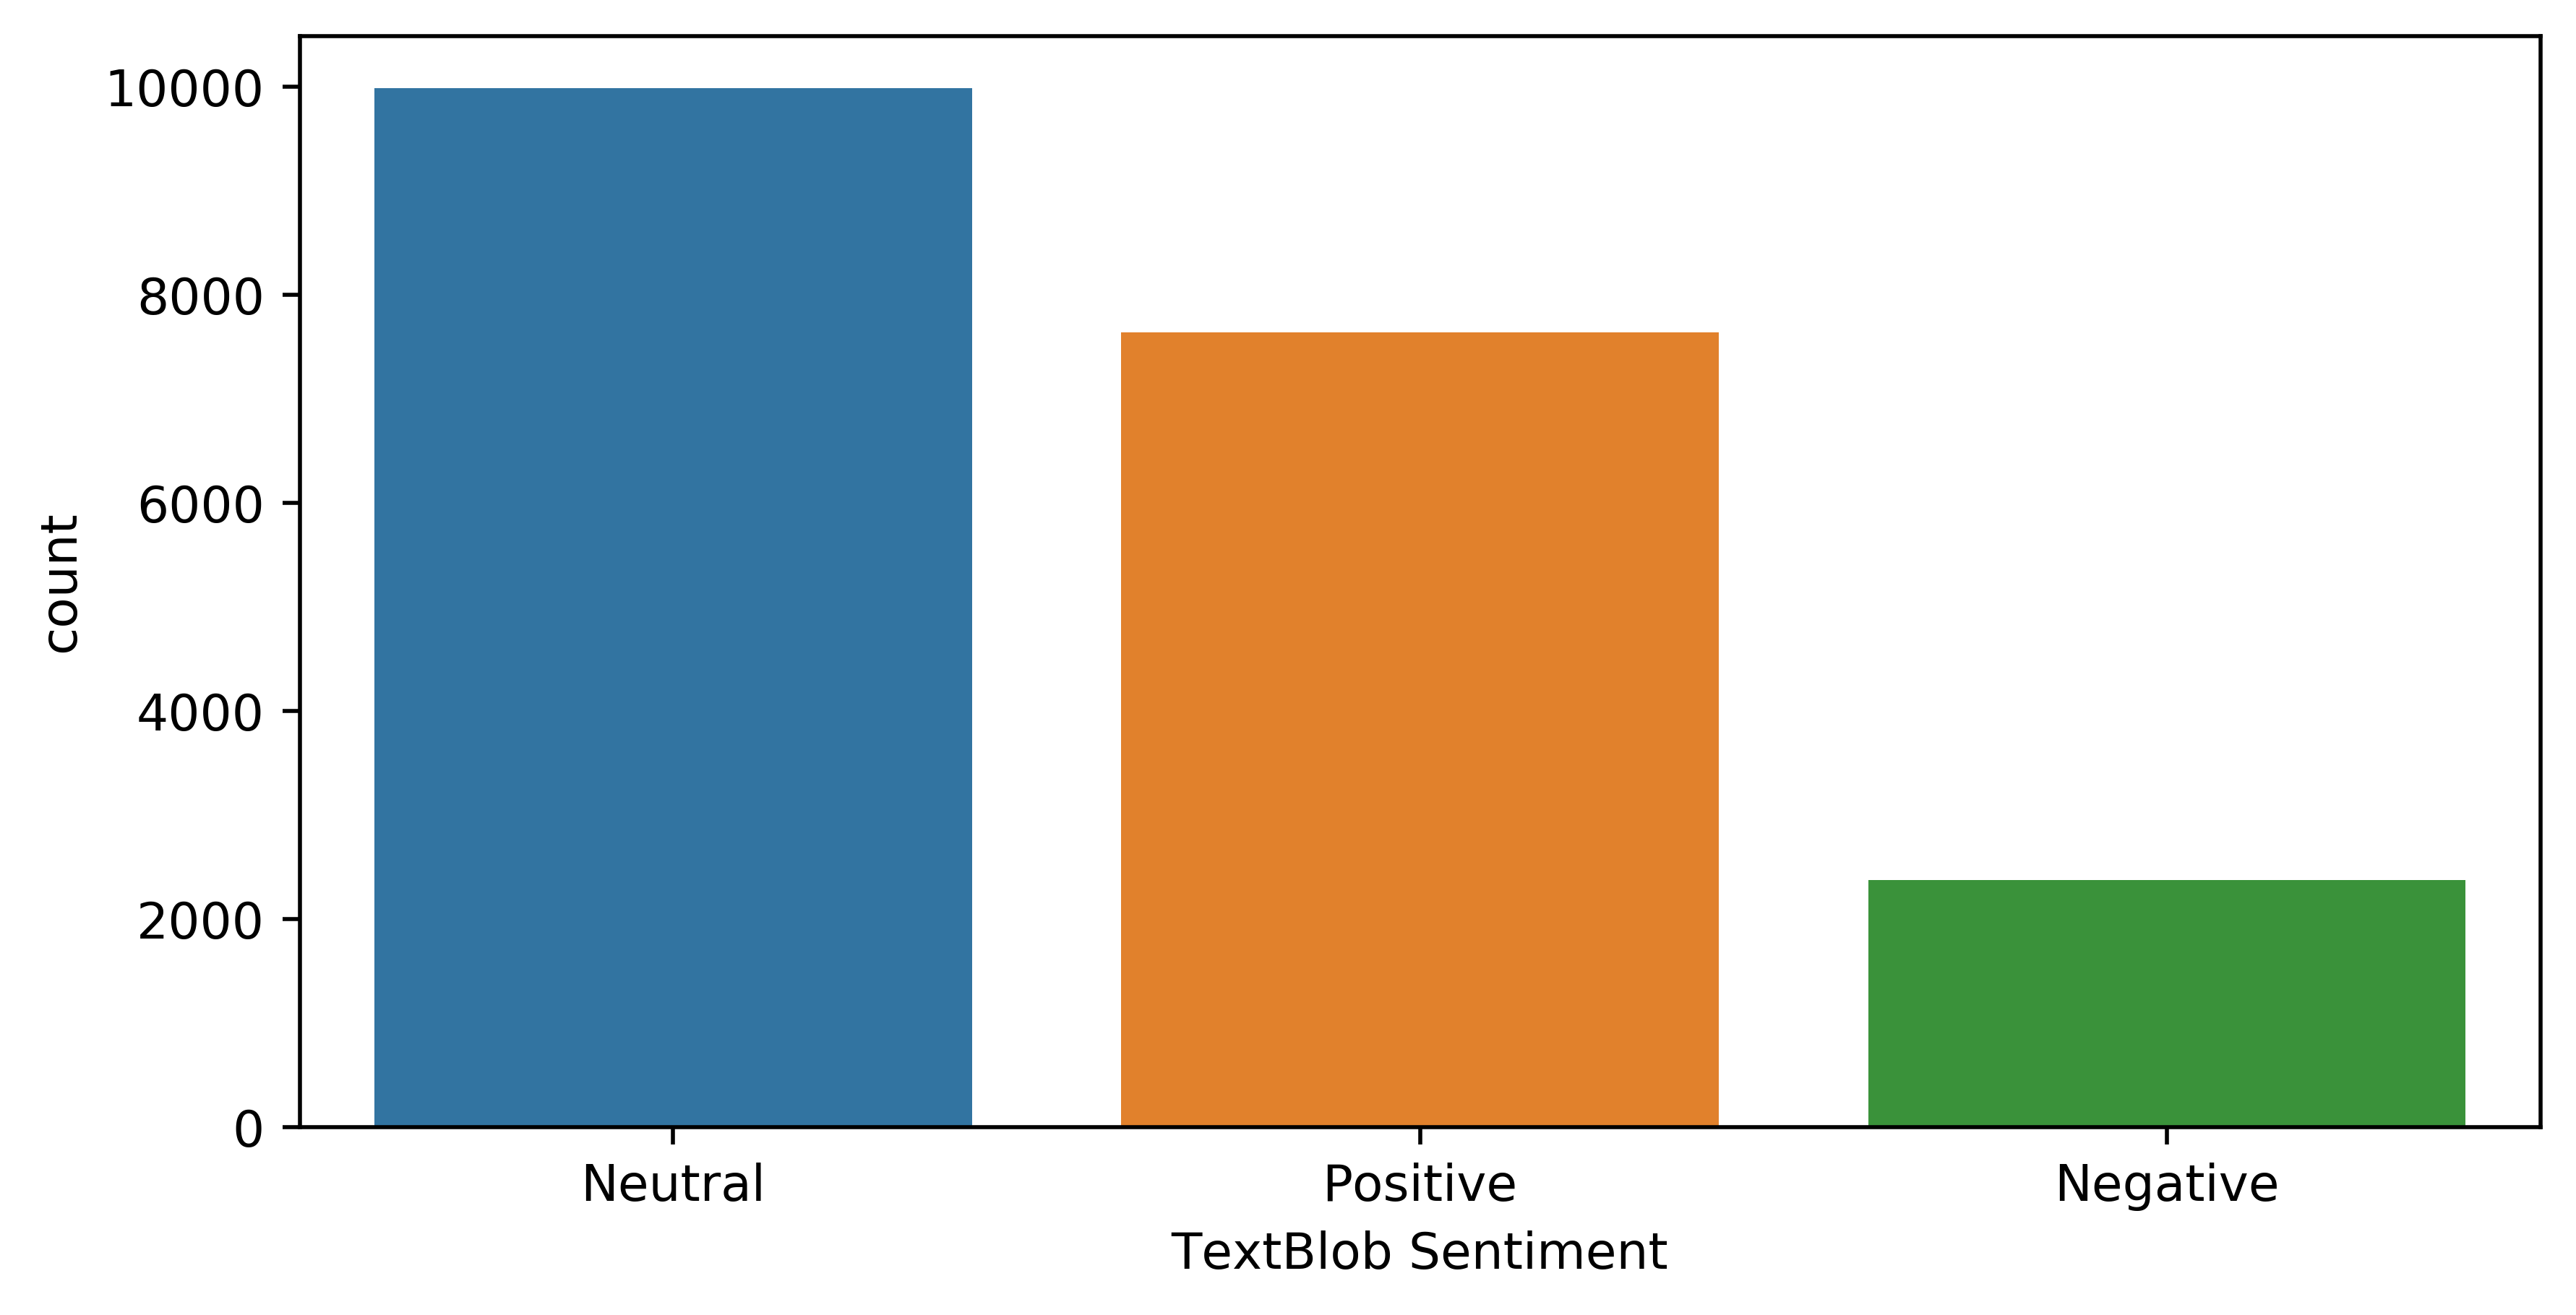

In [32]:
from matplotlib import pyplot
y = data["TextBlob Sentiment"]         
fig, ax = pyplot.subplots(figsize=(8,4),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=data["TextBlob Sentiment"].value_counts().iloc[:15].index )   
plt.savefig('fig3.png')

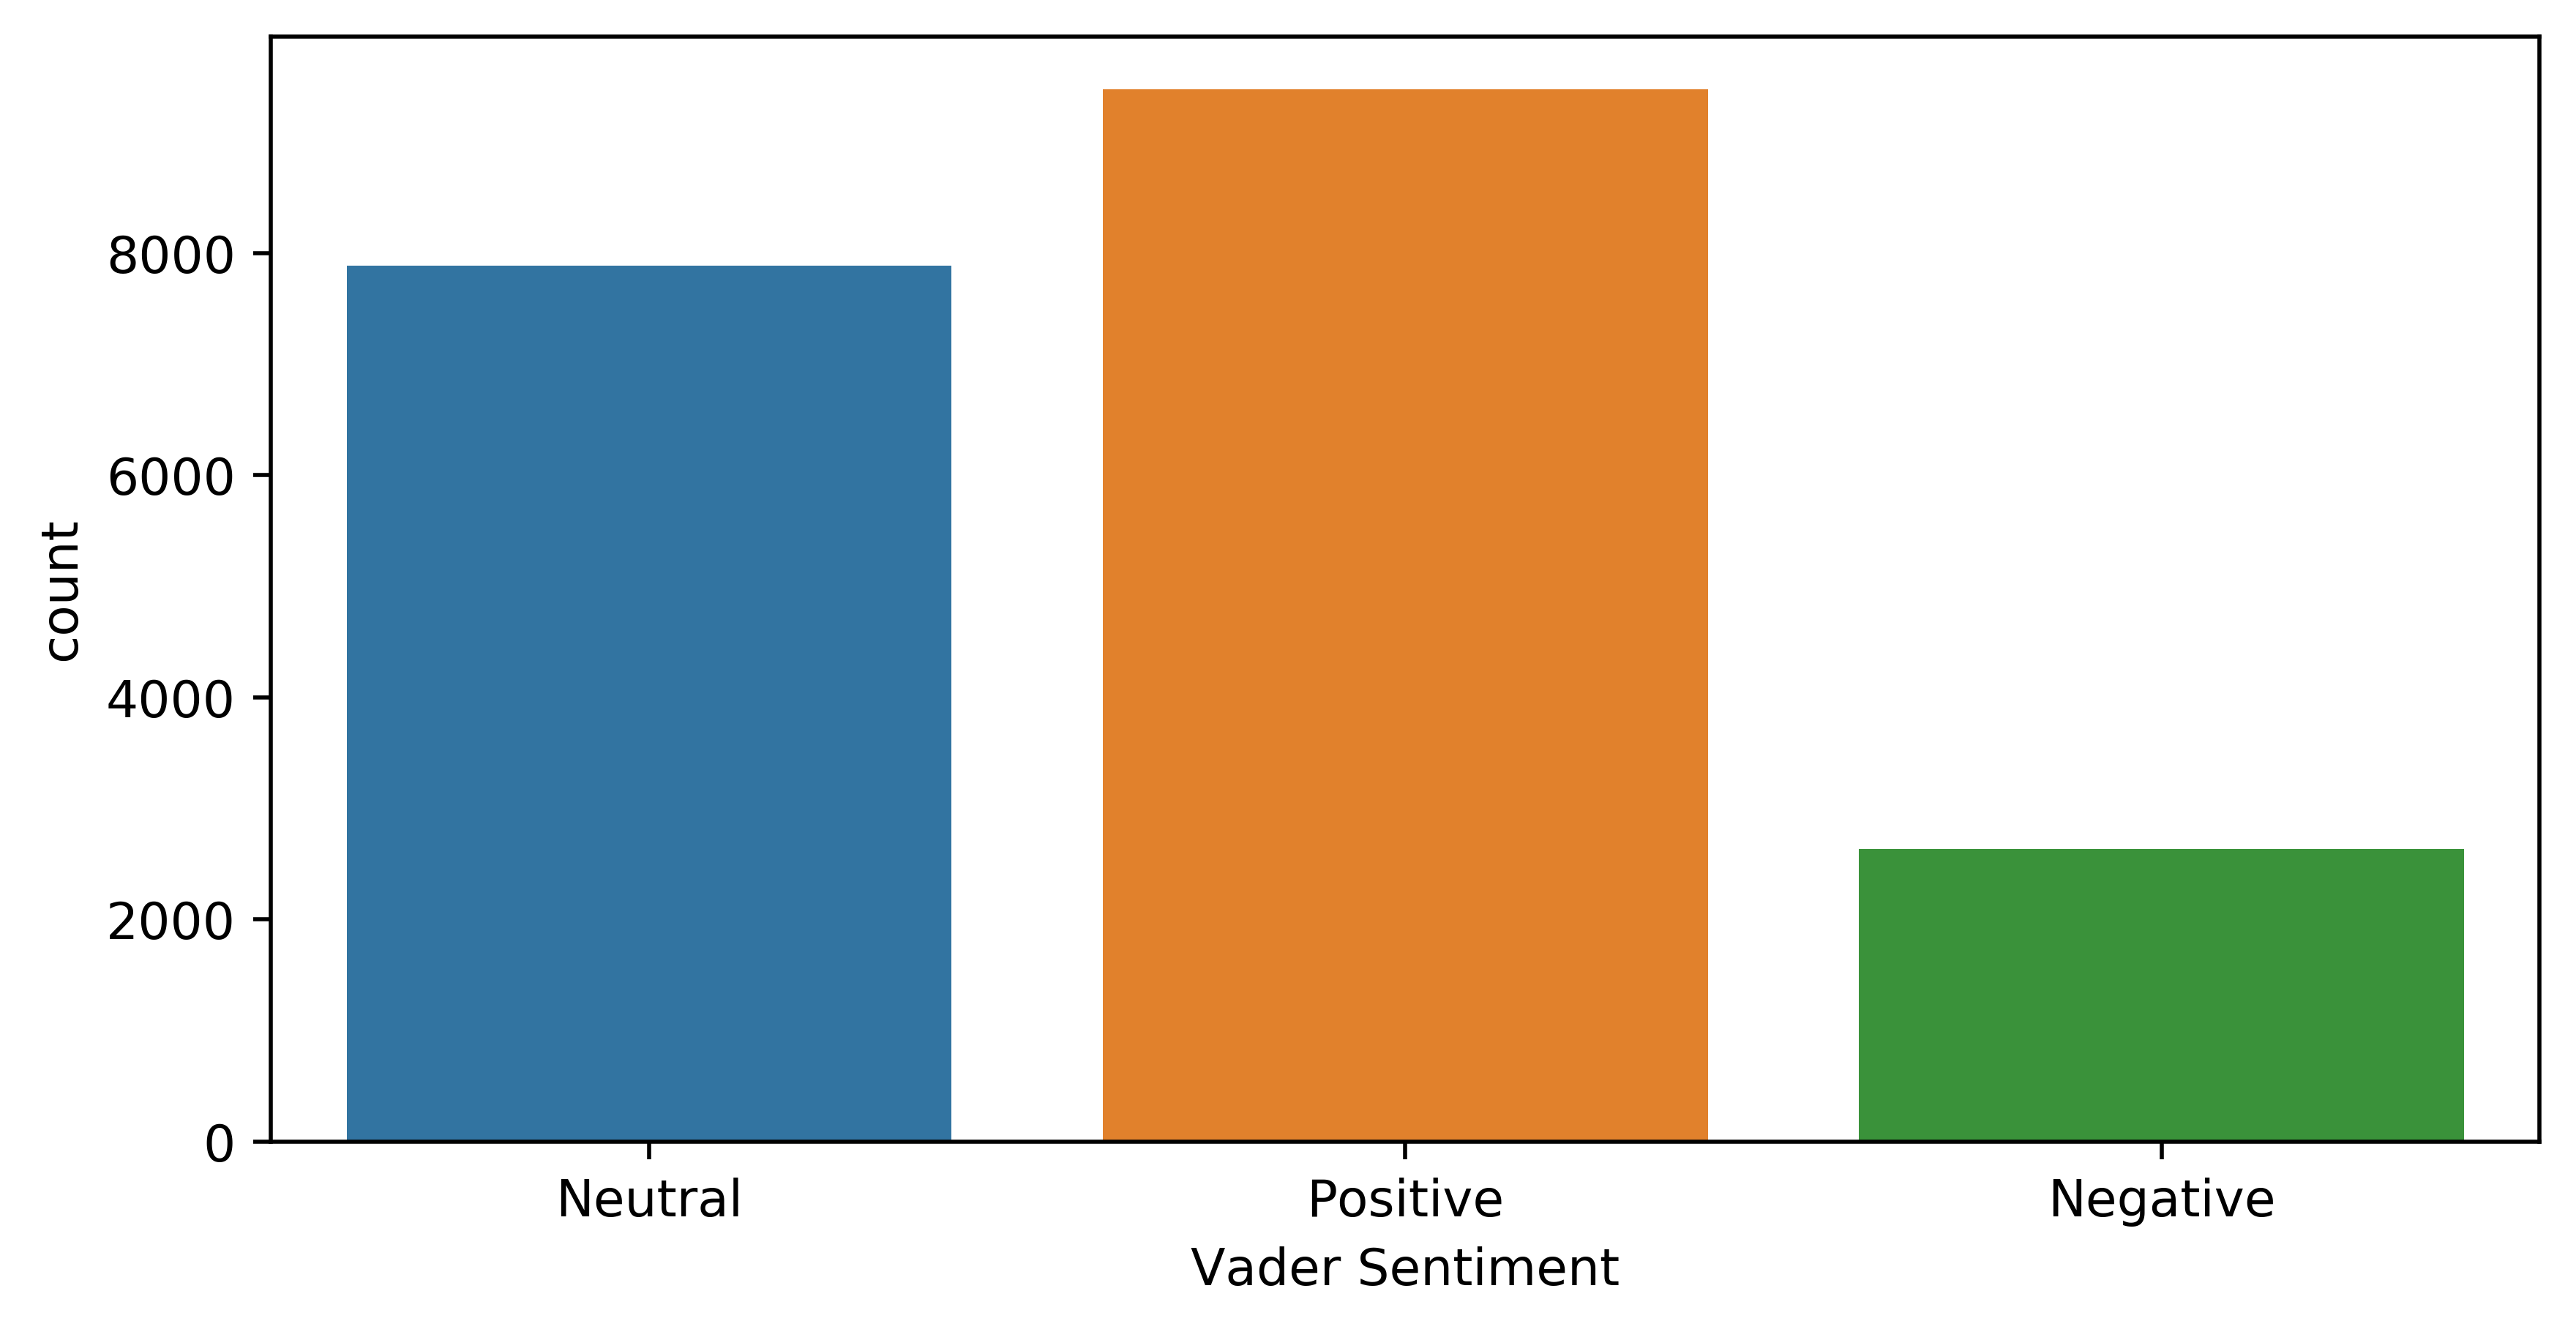

In [33]:
from matplotlib import pyplot
y = data["Vader Sentiment"]         
fig, ax = pyplot.subplots(figsize=(8,4),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=data["TextBlob Sentiment"].value_counts().iloc[:15].index )   
plt.savefig('fig3.png')

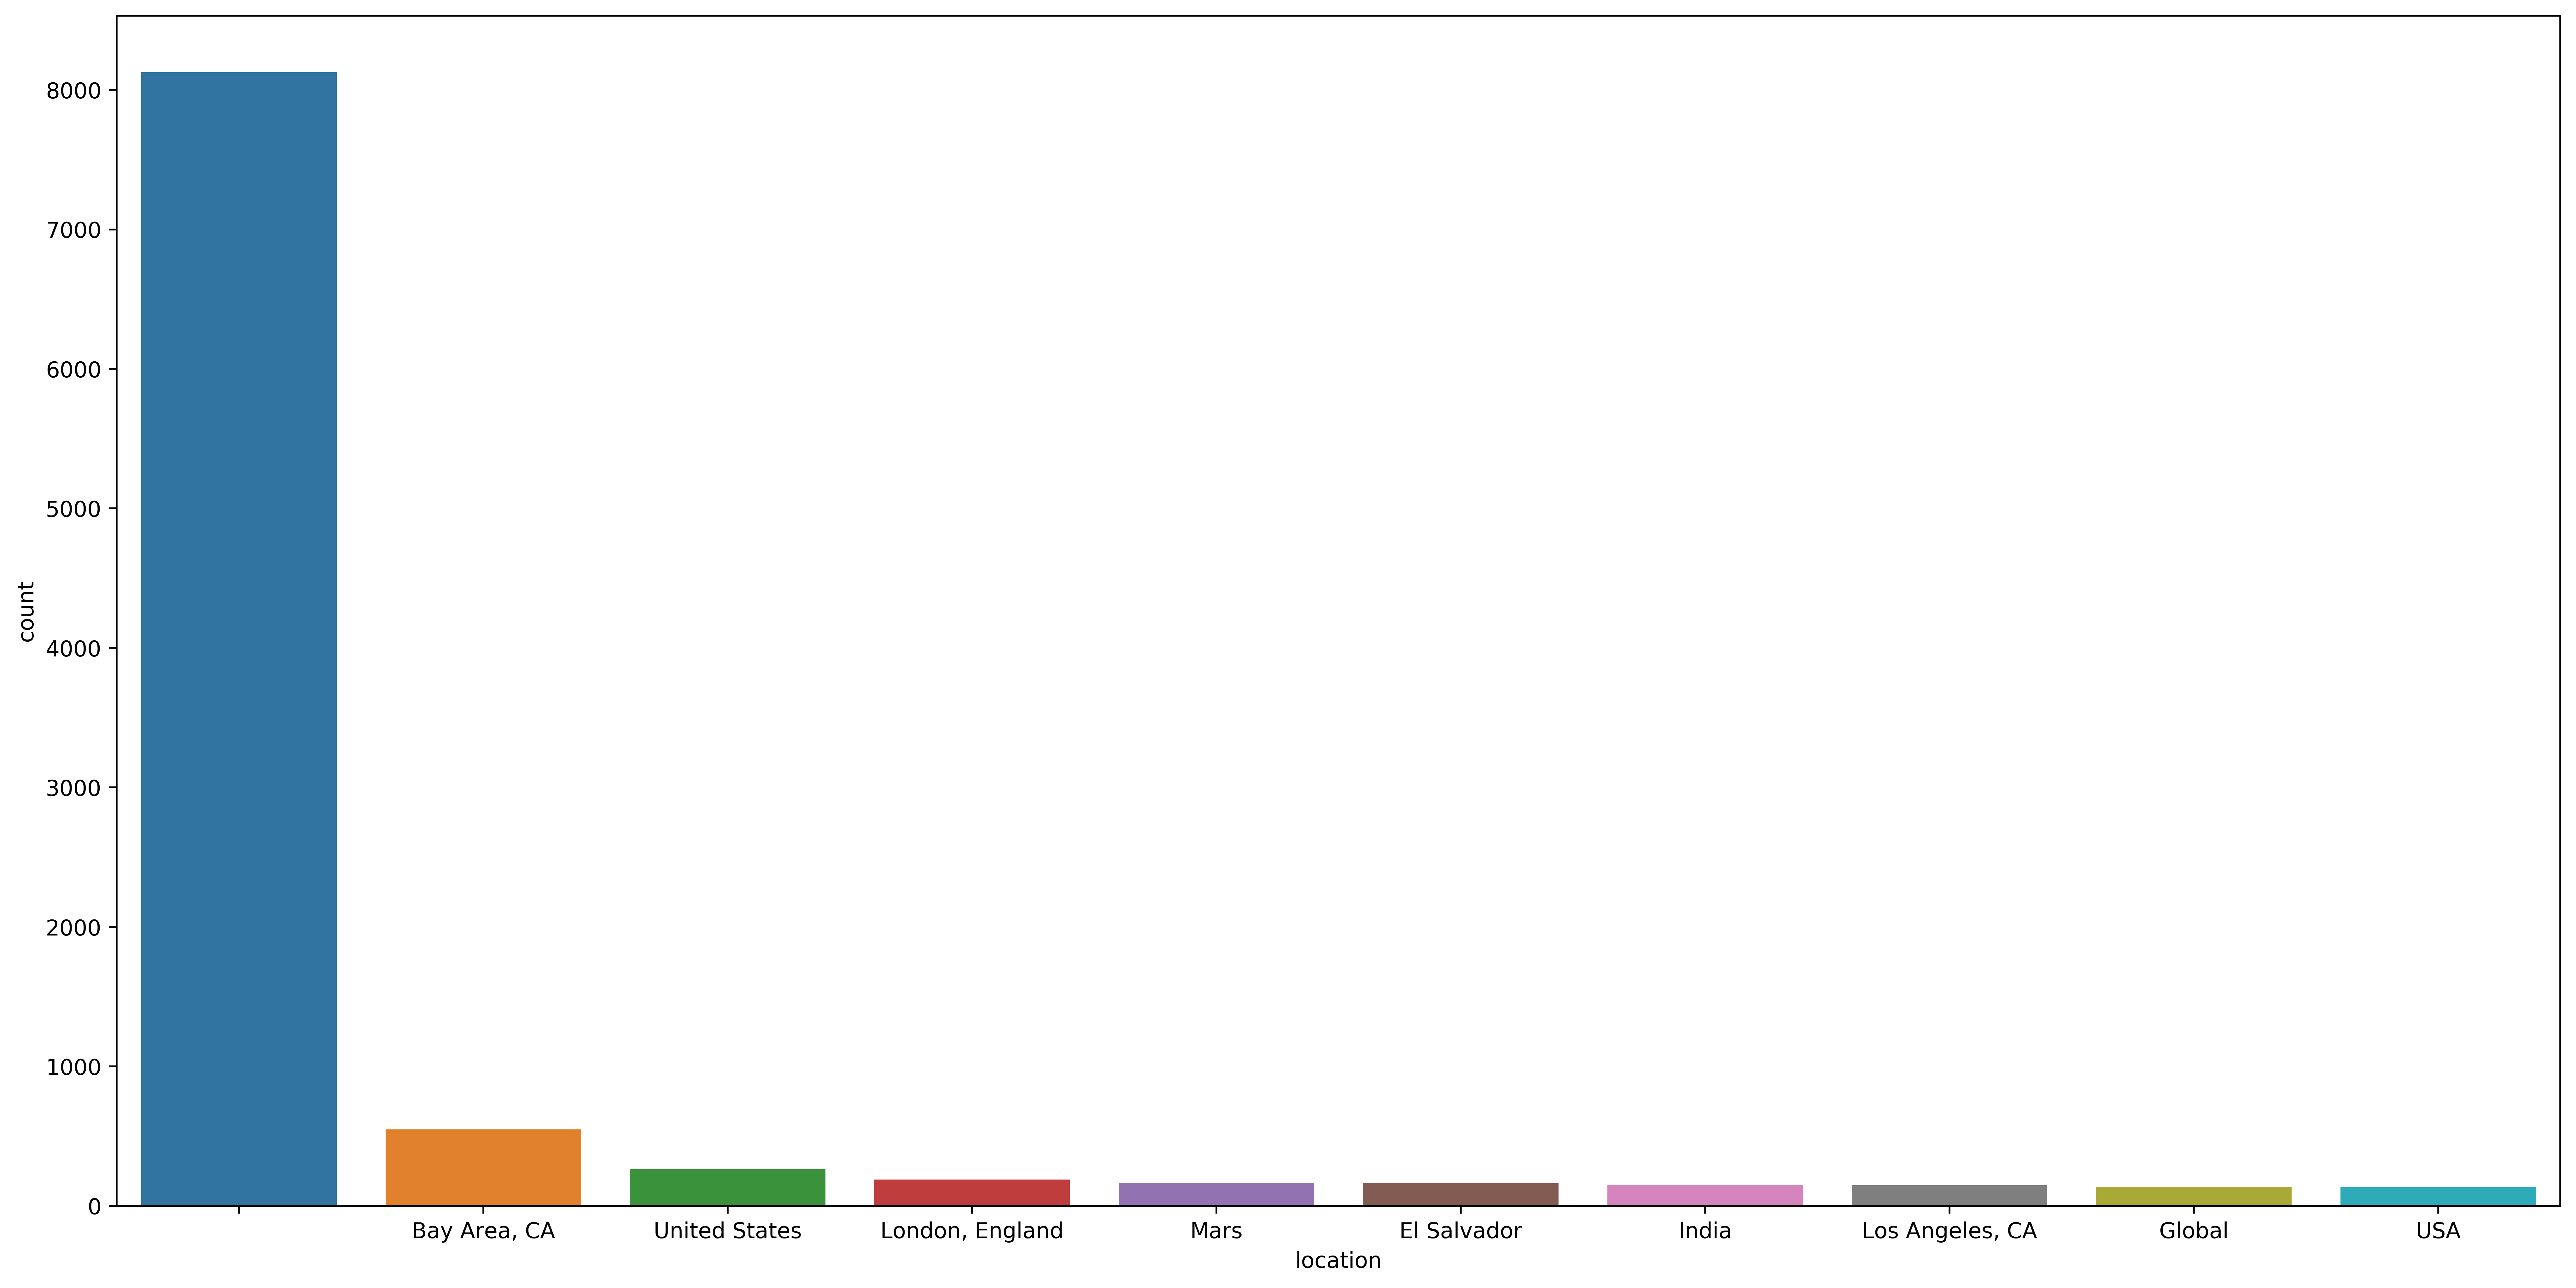

In [54]:
from matplotlib import pyplot
y = data["location"]         
fig, ax = pyplot.subplots(figsize=(20,10),dpi=500)
ax = sns.countplot(y,label="Count",ax=ax,order=data["location"].value_counts().iloc[:10].index )   
plt.savefig('fig3.png')

In [ ]:
# Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["cleanText"].astype(str), data["TextBlob Sentiment"], test_size=0.15, shuffle=True)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
# learn training data vocabulary, then use it to create a document-term matrix
vect = CountVectorizer()
# 3. fit
# 4. transform training data
X_train_dtf = vect.fit_transform(X_train)
X_test_dtf = vect.transform(X_test)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# BoW Features

In [40]:
from sklearn.svm import SVC
print("SVC")
svm = SVC(kernel='linear', C=1.0, random_state=500)
svm.fit(X_train_dtf,y_train)
y_pred=svm.predict(X_test_dtf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

SVC
0.958
              precision    recall  f1-score   support

    Negative       0.93      0.82      0.87       367
     Neutral       0.95      0.99      0.97      1506
    Positive       0.98      0.95      0.97      1127

    accuracy                           0.96      3000
   macro avg       0.95      0.92      0.94      3000
weighted avg       0.96      0.96      0.96      3000

[[ 302   45   20]
 [   4 1497    5]
 [  20   32 1075]]


In [44]:
from sklearn.linear_model import LogisticRegression
# 2. instantiate a logistic regression model
print("LR")
logreg = LogisticRegression(solver='saga',random_state=1000,multi_class='multinomial',C=3.0)
logreg.fit(X_train_dtf,y_train)
y_pred=logreg.predict(X_test_dtf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

LR
0.938
              precision    recall  f1-score   support

    Negative       0.93      0.76      0.83       367
     Neutral       0.92      0.99      0.95      1506
    Positive       0.97      0.93      0.95      1127

    accuracy                           0.94      3000
   macro avg       0.94      0.89      0.91      3000
weighted avg       0.94      0.94      0.94      3000

[[ 278   69   20]
 [   6 1489   11]
 [  16   64 1047]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [45]:
from sklearn.naive_bayes import GaussianNB
# 2. instantiate a GaussianNB model
print("GNB")
gnb = GaussianNB()
gnb.fit(X_train_dtf.toarray(),y_train)
y_pred=gnb.predict(X_test_dtf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

GNB
0.6
              precision    recall  f1-score   support

    Negative       0.22      0.71      0.34       367
     Neutral       0.89      0.49      0.63      1506
    Positive       0.80      0.71      0.75      1127

    accuracy                           0.60      3000
   macro avg       0.64      0.64      0.57      3000
weighted avg       0.77      0.60      0.64      3000

[[260  28  79]
 [642 736 128]
 [262  61 804]]


In [46]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=300, random_state=5, max_depth=300)
print("ExtraTreesClassifier")
etc.fit(X_train_dtf.toarray(),y_train)
y_pred=etc.predict(X_test_dtf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

ExtraTreesClassifier
0.9353333333333333
              precision    recall  f1-score   support

    Negative       0.96      0.73      0.83       367
     Neutral       0.91      0.99      0.95      1506
    Positive       0.96      0.93      0.95      1127

    accuracy                           0.94      3000
   macro avg       0.94      0.88      0.91      3000
weighted avg       0.94      0.94      0.93      3000

[[ 267   72   28]
 [   1 1491   14]
 [  11   68 1048]]


# TF-IDF Features

In [49]:
from sklearn.svm import SVC
print("SVC")
svm = SVC(kernel='linear', C=1.0, random_state=500)
svm.fit(X_train_tf,y_train)
y_pred=svm.predict(X_test_tf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

SVC
0.945
              precision    recall  f1-score   support

    Negative       0.94      0.78      0.85       367
     Neutral       0.93      0.99      0.96      1506
    Positive       0.97      0.94      0.95      1127

    accuracy                           0.94      3000
   macro avg       0.95      0.90      0.92      3000
weighted avg       0.95      0.94      0.94      3000

[[ 286   61   20]
 [   2 1495    9]
 [  15   58 1054]]


In [ ]:
from sklearn.linear_model import LogisticRegression
# LogisticRegression
print("LR")
logreg = LogisticRegression(solver='saga',random_state=1000,multi_class='multinomial',C=3.0)
logreg.fit(X_train_tf,y_train)
y_pred=logreg.predict(X_test_tf)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.naive_bayes import GaussianNB
#GaussianNB
print("GNB")
gnb = GaussianNB()
gnb.fit(X_train_tf.toarray(),y_train)
y_pred=gnb.predict(X_test_tf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=300, random_state=5, max_depth=300)
print("ExtraTreesClassifier")
etc.fit(X_train_tf.toarray(),y_train)
y_pred=etc.predict(X_test_tf.toarray())
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

# Bitcoin price prediction using machine learning models

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator

In [2]:
df=pd.read_csv("BTC_USD Bitfinex Historical Data.csv",index_col='Date', parse_dates=True,infer_datetime_format= True)
df=df.iloc[::-1]

In [3]:
df[:3]

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-02-02,6.1,6.1,6.1,6.1,-,0.00%
2012-02-03,6.0,6.0,6.0,6.0,-,-2.30%
2012-02-04,5.9,5.9,5.9,5.9,-,-1.51%


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


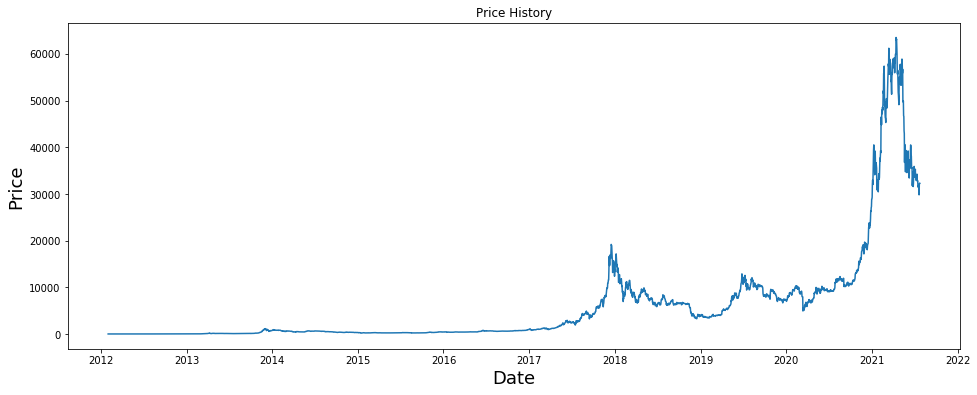

In [4]:
plt.figure(figsize=(16,6))
plt.title('Price History')
plt.plot(df['Price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Price'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

3284

In [6]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[2.99147587e-05],
       [2.83402977e-05],
       [2.67658367e-05],
       ...,
       [5.05981377e-01],
       [5.08799662e-01],
       [5.08270644e-01]])

# LSTM Model

In [7]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([2.99147587e-05, 2.83402977e-05, 2.67658367e-05, 2.36169147e-05,
       1.88935318e-05, 2.36169147e-05, 2.20424538e-05, 2.51913757e-05,
       2.67658367e-05, 2.20424538e-05, 2.04679928e-05, 1.73190708e-05,
       4.72338295e-06, 1.57446098e-06, 1.57446098e-06, 3.14892197e-06,
       0.00000000e+00, 3.14892197e-06, 3.14892197e-06, 1.57446098e-06,
       3.14892197e-06, 1.25956879e-05, 1.25956879e-05, 9.44676590e-06,
       1.10212269e-05, 1.25956879e-05, 1.10212269e-05, 1.10212269e-05,
       1.10212269e-05, 7.87230492e-06, 6.29784393e-06, 9.44676590e-06,
       1.25956879e-05, 1.25956879e-05, 1.10212269e-05, 1.10212269e-05,
       1.10212269e-05, 9.44676590e-06, 1.10212269e-05, 1.10212269e-05,
       1.73190708e-05, 1.88935318e-05, 1.73190708e-05, 1.73190708e-05,
       1.57446098e-05, 1.73190708e-05, 7.87230492e-06, 9.44676590e-06,
       9.44676590e-06, 7.87230492e-06, 7.87230492e-06, 7.87230492e-06,
       6.29784393e-06, 6.29784393e-06, 9.44676590e-06, 9.44676590e-06,
     

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
pred=model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
3224/3224 [==============================] - 59s 14ms/step - loss: 7.0069e-04
Epoch 2/5
3224/3224 [==============================] - 47s 15ms/step - loss: 1.6764e-04
Epoch 3/5
3224/3224 [==============================] - 48s 15ms/step - loss: 1.2628e-04
Epoch 4/5
3224/3224 [==============================] - 48s 15ms/step - loss: 1.1920e-04
Epoch 5/5
3224/3224 [==============================] - 48s 15ms/step - loss: 1.5957e-04


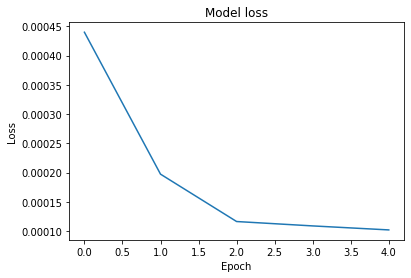

In [9]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(pred.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [10]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2485.783914409003

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


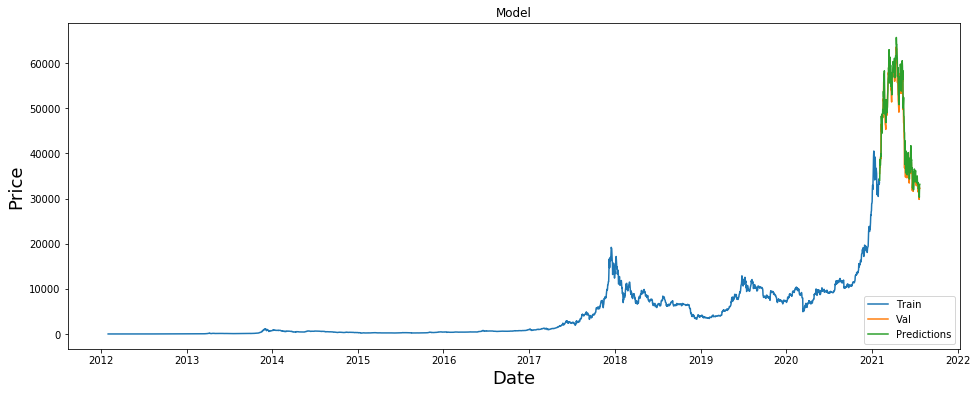

In [11]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [12]:
valid

,Price,Predictions
Date,,
2021-02-02,35563.0,34040.136719
2021-02-03,37677.0,36532.390625
2021-02-04,36975.0,38703.597656
2021-02-05,38260.0,37339.585938
2021-02-06,39257.0,38687.562500
...,...,...
2021-07-19,30847.0,32616.173828
2021-07-20,29806.1,31416.296875
2021-07-21,32141.0,30269.835938


In [13]:

print('MAE:', mean_absolute_error(valid["Price"],valid["Predictions"]))
print('MSE:',mean_squared_error(valid["Price"],valid["Predictions"]))
print('RMSE:',math.sqrt(mean_squared_error(valid["Price"],valid["Predictions"])))
from sklearn.metrics import r2_score
print('R2:',r2_score(valid["Price"],valid["Predictions"]))

MAE: 1949.0592909702036
MSE: 6179121.669134545
RMSE: 2485.783914409003
R2: 0.9393179125683145


# Linear Regression Model

In [14]:
df= pd.read_csv('BTC_USD Bitfinex Historical Data.csv', parse_dates=['Date'], index_col='Date')

In [15]:
df=df.iloc[::-1]

In [16]:
btc=df

In [17]:

btc['ohlc_average'] = (btc['Open'] + btc['High'] + btc['Low'] + btc['Price']) / 4

In [18]:
btc['Price_After_Month']=btc['Price'].shift(-30) #This will be our label
btc.drop(['Vol.','Change %'],axis=1,inplace=True)

In [19]:
#Preprocessing
from sklearn import preprocessing
btc.dropna(inplace=True)
X=btc.drop('Price_After_Month',axis=1)
X1=preprocessing.scale(X)#We need to scale our values to input them in our model
y=btc['Price_After_Month']


In [20]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=101)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
#reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg=LinearRegression()
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 92.0507 %


In [22]:
preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])
#We can see that our predictions are kind of accurate but we still need to work on on them a l

The prediction is: 6951.484649318551 But the real value is: 14997.0


In [27]:

print('MAE:', mean_absolute_error(preds,y_test))
print('MSE:',mean_squared_error(preds,y_test))
print('RMSE:',math.sqrt(mean_squared_error(preds,y_test)))
from sklearn.metrics import r2_score
print('R2:',r2_score(preds,y_test))

MAE: 1303.2449918803266
MSE: 9516202.550514396
RMSE: 3084.8342825043933
R2: 0.917715325562393


In [23]:
#Apply our model and get our prediction
X_30=X[-30:]#We'll take the last 30 elements to make our predictions on them
forecast=reg.predict(X_30)

In [25]:
#creating a new column which contains the predictions!  
from datetime import datetime, timedelta
last_date=btc.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
btc=btc.append(df1)
btc.tail()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,Forecast,High,Low,Open,Price,Price_After_Month,ohlc_average
2021-07-19,34854.275549,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-20,35937.313162,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-21,32206.982618,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-22,33498.264842,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-23,33594.392105,NaN,NaN,NaN,NaN,NaN,NaN


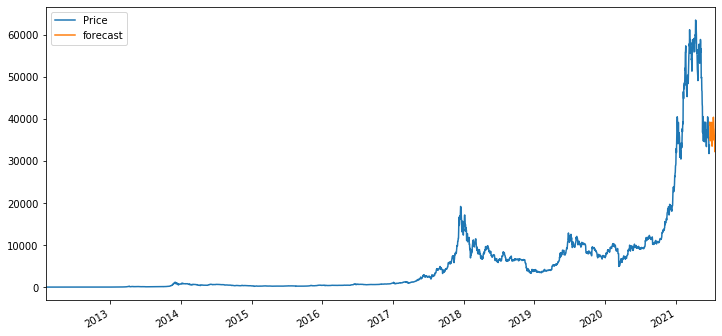

In [26]:
#Now we'll plot our forecast! 
btc['Price'].plot(figsize=(12,6),label='Price')
btc['Forecast'].plot(label='forecast')
plt.legend()

# Random Forest Regressor

Accuracy is: 94.2217 %
The prediction is: 7803.233612325785 But the real value is: 14997.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


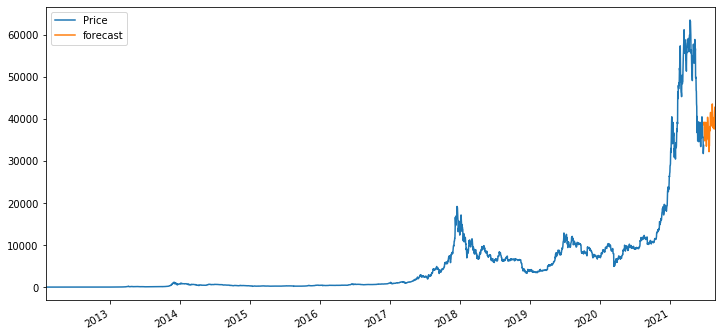

In [28]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=300,max_depth=5)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data


preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])
#We can see that our predictions are kind of accurate but we still need to work on on them a l

#Apply our model and get our prediction
X_30=X[-30:]#We'll take the last 30 elements to make our predictions on them
forecast=reg.predict(X_30)

#creating a new column which contains the predictions! 
#Proceed at your own risk!  
from datetime import datetime, timedelta
last_date=btc.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
btc=btc.append(df1)
btc.tail()


#Now we'll plot our forecast! 
btc['Price'].plot(figsize=(12,6),label='Price')
btc['Forecast'].plot(label='forecast')
plt.legend()

In [29]:
print('MAE:', mean_absolute_error(preds,y_test))
print('MSE:',mean_squared_error(preds,y_test))
print('RMSE:',math.sqrt(mean_squared_error(preds,y_test)))
from sklearn.metrics import r2_score
print('R2:',r2_score(preds,y_test))

MAE: 1098.5690181414589
MSE: 6917246.88664751
RMSE: 2630.0659472050334
R2: 0.9428347716515982


Reference:
1: https://medium.com/atoti/is-it-enough-to-focus-just-on-twitter-sentiment-9e1f65a867c2
2: https://medium.com/atoti/how-im-failing-my-twitter-sentiment-analysis-for-cryptocurrency-prediction-149a1730a6fd
3: https://www.youtube.com/watch?t=939&v=tepxdcepTbY&feature=youtu.be